## Library Installation

In [1]:
"""!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install opencv-python
!pip install matplotlib
!pip install seaborn
!pip install tensorflow # Or !pip install torch torchvision torchaudio
!pip install Pillow"""

'!pip install numpy\n!pip install pandas\n!pip install scikit-learn\n!pip install opencv-python\n!pip install matplotlib\n!pip install seaborn\n!pip install tensorflow # Or !pip install torch torchvision torchaudio\n!pip install Pillow'

## Importing Libraries

In [2]:
# %% [markdown]
# # BBM 409 - Assignment 4: Bird Species Classification
# ## Part 0: Data Loading, Preprocessing, and Visualization
# %% Setup: Imports and Global Parameters
import os
import cv2 # OpenCV for image manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical # For one-hot encoding
import random
import pandas as pd
from sklearn.manifold import TSNE # For t-SNE visualization
from sklearn.preprocessing import StandardScaler # For t-SNE
from skimage.feature import hog, local_binary_pattern # <-- YENİ EKLEME
# --- USER CONFIGURABLE PARAMETERS ---
# !!! IMPORTANT: SET THIS TO YOUR DATASET PATH !!!
DATASET_BASE_DIR = 'Birds_25'  # Path to your 'Birds_25' directory

# Image dimensions for model input
IMG_WIDTH = 28
IMG_HEIGHT = 28

NUM_CLASSES = 25 # As per the assignment
# --- END USER CONFIGURABLE PARAMETERS ---

TRAIN_DIR = os.path.join(DATASET_BASE_DIR, 'train')
VALID_DIR = os.path.join(DATASET_BASE_DIR, 'valid')

2025-05-28 20:18:12.331038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748452692.423323  231154 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748452692.446991  231154 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748452692.622542  231154 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748452692.622562  231154 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748452692.622565  231154 computation_placer.cc:177] computation placer alr

## PART 0: DATA VISUALIZATION AND DATA PREPROCESSING

### Step 1: Discover Species and Collect Image Paths

In [3]:
# %% [markdown]

# %% Step 1 Code
species_list = []
if os.path.exists(TRAIN_DIR):
    species_list = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
else:
    print(f"Warning: Training directory not found at '{TRAIN_DIR}'. Cannot determine species list automatically.")

if not species_list:
    print("Species list is empty. Please ensure your dataset is structured correctly and DATASET_BASE_DIR is set.")
else:
    print(f"Found {len(species_list)} species: {species_list[:5]}... (first 5 shown)")
    if len(species_list) != NUM_CLASSES:
        print(f"Warning: Found {len(species_list)} species folders, but expected {NUM_CLASSES}.")

all_original_train_paths = []
all_original_train_labels_str = []
all_original_valid_paths = []
all_original_valid_labels_str = []

for species_name in species_list:
    species_train_dir = os.path.join(TRAIN_DIR, species_name)
    if os.path.isdir(species_train_dir):
        for img_file in os.listdir(species_train_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_original_train_paths.append(os.path.join(species_train_dir, img_file))
                all_original_train_labels_str.append(species_name)

    species_valid_dir = os.path.join(VALID_DIR, species_name)
    if os.path.isdir(species_valid_dir):
        for img_file in os.listdir(species_valid_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_original_valid_paths.append(os.path.join(species_valid_dir, img_file))
                all_original_valid_labels_str.append(species_name)

print(f"\nTotal original training image paths collected: {len(all_original_train_paths)}")
print(f"Total original validation image paths collected: {len(all_original_valid_paths)}")

Found 25 species: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna']... (first 5 shown)

Total original training image paths collected: 30000
Total original validation image paths collected: 7500


### Step 2: Encode Labels and Prepare 80-10-10 Split Paths


In [4]:
# %% Step 2 Code
label_encoder = LabelEncoder()
all_original_train_labels_encoded = label_encoder.fit_transform(all_original_train_labels_str)
all_original_valid_labels_encoded = label_encoder.transform(all_original_valid_labels_str)

label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print("\nLabel mapping (numerical_label: species_name):")
for i in range(min(5, len(label_mapping))): # Print first 5
    print(f"{i}: {label_mapping[i]}")
if len(label_mapping) > 5: print("...")


X_train_paths = []
y_train_labels_encoded = []
X_val_paths = []
y_val_labels_encoded = []
X_test_paths = []
y_test_labels_encoded = []

# Populate final training set (all original training images)
for i in range(len(all_original_train_paths)):
    X_train_paths.append(all_original_train_paths[i])
    y_train_labels_encoded.append(all_original_train_labels_encoded[i])

# Split original validation images per class into new validation and test sets
original_valid_paths_by_class = {}
for path, label_enc in zip(all_original_valid_paths, all_original_valid_labels_encoded):
    if label_enc not in original_valid_paths_by_class:
        original_valid_paths_by_class[label_enc] = []
    original_valid_paths_by_class[label_enc].append(path)

for class_label_enc, paths_for_class in original_valid_paths_by_class.items():
    species_name_temp = label_encoder.inverse_transform([class_label_enc])[0]
    if len(paths_for_class) != 300: # As per dataset description
        print(f"Info: Species '{species_name_temp}' has {len(paths_for_class)} original validation images (expected 300). Adjusting split.")
    
    random.shuffle(paths_for_class)
    split_point = len(paths_for_class) // 2

    X_val_paths.extend(paths_for_class[:split_point])
    y_val_labels_encoded.extend([class_label_enc] * len(paths_for_class[:split_point]))
    X_test_paths.extend(paths_for_class[split_point:])
    y_test_labels_encoded.extend([class_label_enc] * len(paths_for_class[split_point:]))

print(f"\n--- Dataset Split Path Counts ---")
print(f"Final training image paths: {len(X_train_paths)}")
print(f"Final validation image paths: {len(X_val_paths)}")
print(f"Final test image paths: {len(X_test_paths)}")

y_train_labels_encoded = np.array(y_train_labels_encoded)
y_val_labels_encoded = np.array(y_val_labels_encoded)
y_test_labels_encoded = np.array(y_test_labels_encoded)



Label mapping (numerical_label: species_name):
0: Asian-Green-Bee-Eater
1: Brown-Headed-Barbet
2: Cattle-Egret
3: Common-Kingfisher
4: Common-Myna
...

--- Dataset Split Path Counts ---
Final training image paths: 30000
Final validation image paths: 3750
Final test image paths: 3750


In [5]:
# %% --- Part 0 Update: Optimized Image Loading and Label Filtering (Run Once After Part 0 Splits) ---
print("--- Loading and Resizing All Images (BGR) and Filtering Labels ---")

def load_resize_and_filter_bgr(image_paths, original_labels, target_width, target_height):
    loaded_images_bgr = []
    filtered_labels = []
    successfully_loaded_paths = [] # Keep track of paths that were loaded
    skipped_count = 0
    
    print(f"Attempting to load and resize {len(image_paths)} images to ({target_width}x{target_height})...")
    for i, img_path in enumerate(image_paths):
        img_bgr = cv2.imread(img_path) # Load as BGR
        if img_bgr is None:
            print(f"Warning: Could not load {img_path} at index {i}, skipping.")
            skipped_count += 1
            continue
        
        try:
            img_bgr_resized = cv2.resize(img_bgr, (target_width, target_height))
            loaded_images_bgr.append(img_bgr_resized)
            filtered_labels.append(original_labels[i])
            successfully_loaded_paths.append(img_path)
        except Exception as e:
            print(f"Error resizing {img_path}: {e}, skipping.")
            skipped_count += 1
            continue

        if (i + 1) % 500 == 0 or (i + 1) == len(image_paths):
            print(f"  Processed {i+1}/{len(image_paths)} images.")
            
    print(f"Finished. Successfully loaded and resized {len(loaded_images_bgr)} images. Skipped {skipped_count} images.")
    return np.array(loaded_images_bgr), np.array(filtered_labels), successfully_loaded_paths

# Assuming X_train_paths, y_train_labels_encoded, etc. are from your Part 0 - Step 2
# And IMG_WIDTH, IMG_HEIGHT are defined in Part 0 - Setup

# These will hold the actual image data in BGR format, resized.
X_train_images_bgr, y_train_final, X_train_paths_final = load_resize_and_filter_bgr(X_train_paths, y_train_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
X_val_images_bgr, y_val_final, X_val_paths_final = load_resize_and_filter_bgr(X_val_paths, y_val_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
X_test_images_bgr, y_test_final, X_test_paths_final = load_resize_and_filter_bgr(X_test_paths, y_test_labels_encoded, IMG_WIDTH, IMG_HEIGHT)

print("\n--- Final Data Shapes After Loading and Filtering ---")
if X_train_images_bgr.size > 0: print(f"X_train_images_bgr shape: {X_train_images_bgr.shape}, y_train_final shape: {y_train_final.shape}")
if X_val_images_bgr.size > 0: print(f"X_val_images_bgr shape: {X_val_images_bgr.shape}, y_val_final shape: {y_val_final.shape}")
if X_test_images_bgr.size > 0: print(f"X_test_images_bgr shape: {X_test_images_bgr.shape}, y_test_final shape: {y_test_final.shape}")

# target_names_part1 will be used in Part 1 for classification reports
if 'label_mapping' in globals():
    target_names_part1 = [label_mapping[i] for i in sorted(label_mapping.keys())]
else: # Fallback if label_mapping is not available
    print("Warning: label_mapping not found. Classification report might use numerical labels.")
    unique_labels_for_target_names = np.unique(np.concatenate([y_train_final, y_val_final, y_test_final]))
    target_names_part1 = [str(i) for i in unique_labels_for_target_names]

# Update NUM_CLASSES based on actual unique labels found after filtering, if necessary
if 'NUM_CLASSES' in globals():
    if len(np.unique(y_train_final)) != NUM_CLASSES: #
        print(f"Warning: Number of unique labels in y_train_final ({len(np.unique(y_train_final))}) does not match NUM_CLASSES ({NUM_CLASSES}).")
        # Consider updating NUM_CLASSES if appropriate for your project logic downstream
        # NUM_CLASSES = len(np.unique(y_train_final))
else:
    NUM_CLASSES = len(np.unique(y_train_final))
    print(f"NUM_CLASSES not defined, setting to {NUM_CLASSES} based on y_train_final.")

--- Loading and Resizing All Images (BGR) and Filtering Labels ---
Attempting to load and resize 30000 images to (28x28)...
  Processed 500/30000 images.
  Processed 1000/30000 images.
  Processed 1500/30000 images.
  Processed 2000/30000 images.
  Processed 2500/30000 images.
  Processed 3000/30000 images.
  Processed 3500/30000 images.
  Processed 4000/30000 images.
  Processed 4500/30000 images.
  Processed 5000/30000 images.
  Processed 5500/30000 images.
  Processed 6000/30000 images.
  Processed 6500/30000 images.
  Processed 7000/30000 images.
  Processed 7500/30000 images.
  Processed 8000/30000 images.
  Processed 8500/30000 images.
  Processed 9000/30000 images.
  Processed 9500/30000 images.
  Processed 10000/30000 images.
  Processed 10500/30000 images.
  Processed 11000/30000 images.
  Processed 11500/30000 images.
  Processed 12000/30000 images.
  Processed 12500/30000 images.
  Processed 13000/30000 images.
  Processed 13500/30000 images.
  Processed 14000/30000 images.


### Step 3: Image Loading and Preprocessing Functions (Separated)


In [6]:
# %% Step 3 Code
def load_raw_image_from_path(image_path):
    try:
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            print(f"Warning (load_raw_image_from_path): Could not read image {image_path}.")
            return None
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        return img_rgb
    except Exception as e:
        print(f"Error loading raw image {image_path}: {e}")
        return None

def apply_model_preprocessing(raw_image_rgb, target_width, target_height):
    if raw_image_rgb is None: return None
    try:
        img_resized = cv2.resize(raw_image_rgb, (target_width, target_height))
        img_normalized = img_resized.astype('float32') / 255.0
        return img_normalized
    except Exception as e:
        print(f"Error applying model preprocessing: {e}")
        return None

def load_and_preprocess_data_separated(image_paths_list, labels_encoded_list, target_width, target_height):
    data, labels = [], []
    print(f"Starting to load and preprocess {len(image_paths_list)} images...")
    for i, path in enumerate(image_paths_list):
        raw_img = load_raw_image_from_path(path)
        if raw_img is not None:
            processed_img = apply_model_preprocessing(raw_img, target_width, target_height)
            if processed_img is not None:
                data.append(processed_img)
                labels.append(labels_encoded_list[i])
        if (i + 1) % 500 == 0 or (i + 1) == len(image_paths_list):
             print(f"  Processed {i+1}/{len(image_paths_list)} images for current set.")
    print(f"Finished. Successfully processed {len(data)} out of {len(image_paths_list)} images.")
    return np.array(data), np.array(labels)

# %% [markdown]


### Step 4: Visualization Functions


In [7]:

# %% Step 4 Code
def display_sample_images_from_paths(image_paths_list, numeric_labels_list, label_mapping_dict,
                                     num_samples_per_class=3, num_classes_to_display=5, title_prefix="Sample Raw"):
    if not image_paths_list or not numeric_labels_list.size:
        print("Image paths list or labels list is empty.")
        return

    paths_by_class = {}
    for path, label_numeric in zip(image_paths_list, numeric_labels_list):
        if label_numeric not in paths_by_class: paths_by_class[label_numeric] = []
        paths_by_class[label_numeric].append(path)

    unique_labels_available = list(paths_by_class.keys())
    if not unique_labels_available: return

    selected_labels_numeric = random.sample(unique_labels_available, min(num_classes_to_display, len(unique_labels_available)))

    plt.figure(figsize=(15, 3 * len(selected_labels_numeric)))
    plot_idx = 1
    for label_numeric in selected_labels_numeric:
        class_name = label_mapping_dict.get(label_numeric, f"Unknown {label_numeric}")
        class_image_paths = paths_by_class.get(label_numeric, [])
        sample_paths = random.sample(class_image_paths, min(num_samples_per_class, len(class_image_paths)))
        for i, img_path in enumerate(sample_paths):
            plt.subplot(len(selected_labels_numeric), num_samples_per_class, plot_idx)
            raw_img_to_display = load_raw_image_from_path(img_path)
            if raw_img_to_display is not None:
                plt.imshow(raw_img_to_display)
                plt.title(f"{title_prefix}: {class_name}\n(Original Dim.)")
            else:
                plt.title(f"{class_name}\nFailed to load")
            plt.axis('off')
            plot_idx += 1
    plt.suptitle(f"{title_prefix} Images Per Class", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

def plot_class_distribution(y_numeric_list, label_mapping_dict, dataset_name="Dataset"):
    if not y_numeric_list.size:
        print(f"Label array for {dataset_name} is empty.")
        return
    unique_labels, counts = np.unique(y_numeric_list, return_counts=True)
    class_names = [label_mapping_dict.get(label, f"Unknown {label}") for label in unique_labels]
    
    df_counts = pd.DataFrame({'Species': class_names, 'Count': counts}).sort_values('Species')

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")
    plt.title(f'Class Distribution in {dataset_name} (Total: {sum(counts)} images)', fontsize=15)
    plt.xlabel('Bird Species', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xticks(rotation=90, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def show_downscaling_effect_from_path(original_image_path, target_width, target_height):
    raw_img = load_raw_image_from_path(original_image_path)
    if raw_img is None:
        print(f"Could not load image for downscaling demo: {original_image_path}")
        return
    
    # Preprocess for downscaled version
    processed_img = apply_model_preprocessing(raw_img, target_width, target_height)
    if processed_img is None:
        print(f"Could not preprocess image for downscaling demo: {original_image_path}")
        return

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(raw_img)
    plt.title(f'Original Image\n({raw_img.shape[1]}x{raw_img.shape[0]})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_img) # This is normalized, imshow handles [0,1] floats
    plt.title(f'Downscaled & Normalized\n({target_width}x{target_height})')
    plt.axis('off')
    plt.suptitle("Image Downscaling and Preprocessing Effect", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def display_average_processed_images(X_processed, y_numeric_list, label_mapping_dict, num_classes_to_display=5):
    if not X_processed.size or not y_numeric_list.size:
        print("Processed data or labels are empty for average image display.")
        return
    unique_labels = np.unique(y_numeric_list)
    selected_labels = random.sample(list(unique_labels), min(num_classes_to_display, len(unique_labels)))
    
    plt.figure(figsize=(15, 3))
    for i, label_numeric in enumerate(selected_labels):
        class_images = X_processed[y_numeric_list == label_numeric]
        if class_images.shape[0] == 0: continue
        average_image = np.mean(class_images, axis=0)
        average_image = np.clip(average_image, 0, 1) # Ensure vals are in [0,1]

        plt.subplot(1, len(selected_labels), i + 1)
        plt.imshow(average_image)
        plt.title(f"Avg: {label_mapping_dict.get(label_numeric, str(label_numeric))}")
        plt.axis('off')
    plt.suptitle("Average Processed Images Per Class", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

def plot_color_histograms_for_raw_image(raw_image_rgb, title="Color Histogram"):
    if raw_image_rgb is None: return
    colors, channel_names = ('r', 'g', 'b'), ('Red', 'Green', 'Blue')
    plt.figure(figsize=(10, 5))
    plt.suptitle(title, fontsize=14)
    for i, color in enumerate(colors):
        # Ensure image is uint8 for calcHist if it's not already
        img_for_hist = raw_image_rgb
        if raw_image_rgb.dtype != np.uint8:
             # If it was float [0,1] for some reason, scale. But load_raw_image should give uint8.
             if raw_image_rgb.max() <= 1.0 and raw_image_rgb.min() >=0.0 :
                 img_for_hist = (raw_image_rgb * 255).astype(np.uint8)
             else: # Assume it's already in a good range for uint8 conversion
                 img_for_hist = raw_image_rgb.astype(np.uint8)

        histogram = cv2.calcHist([img_for_hist], [i], None, [256], [0, 256])
        plt.plot(histogram, color=color, label=f'{channel_names[i]} channel')
    plt.xlabel("Pixel Intensity (0-255)"); plt.ylabel("Number of Pixels")
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.7); plt.xlim([0, 256])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_tsne_visualization_of_processed(X_processed, y_numeric_list, label_mapping_dict, n_samples_subset=1000, perplexity_val=30):
    if not X_processed.size or not y_numeric_list.size:
        print("Processed data or labels are empty for t-SNE.")
        return
    actual_samples = min(n_samples_subset, X_processed.shape[0])
    if actual_samples < perplexity_val + 2 : # Perplexity must be less than n_samples - 1
        print(f"Subset size {actual_samples} is too small for perplexity {perplexity_val}. Skipping t-SNE or try larger subset/smaller perplexity.")
        return
        
    print(f"\nPerforming t-SNE on a subset of {actual_samples} processed samples...")
    indices = np.random.choice(X_processed.shape[0], actual_samples, replace=False)
    X_subset, y_subset = X_processed[indices], y_numeric_list[indices]
    X_flattened = X_subset.reshape(actual_samples, -1)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flattened)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(perplexity_val, actual_samples-2), n_iter=300, verbose=0)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(14, 10))
    unique_labels_in_subset = np.unique(y_subset)
    cmap = plt.cm.get_cmap('turbo', len(unique_labels_in_subset))

    for i, label_numeric in enumerate(unique_labels_in_subset):
        class_name = label_mapping_dict.get(label_numeric, str(label_numeric))
        plt.scatter(X_tsne[y_subset == label_numeric, 0], X_tsne[y_subset == label_numeric, 1],
                    label=class_name, alpha=0.8, color=cmap(i), s=50)
    plt.title(f't-SNE Visualization of {actual_samples} Processed Image Samples', fontsize=15)
    plt.xlabel('t-SNE Component 1'); plt.ylabel('t-SNE Component 2')
    if len(unique_labels_in_subset) <= 25: # Adjust if too many for legend
        plt.legend(loc='best', markerscale=1.0, bbox_to_anchor=(1.05, 1), title="Species")
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Make space for legend
    plt.show()


### Step 5: Data Visualizations of Original Data



--- Displaying Sample Raw Images from Training Paths ---


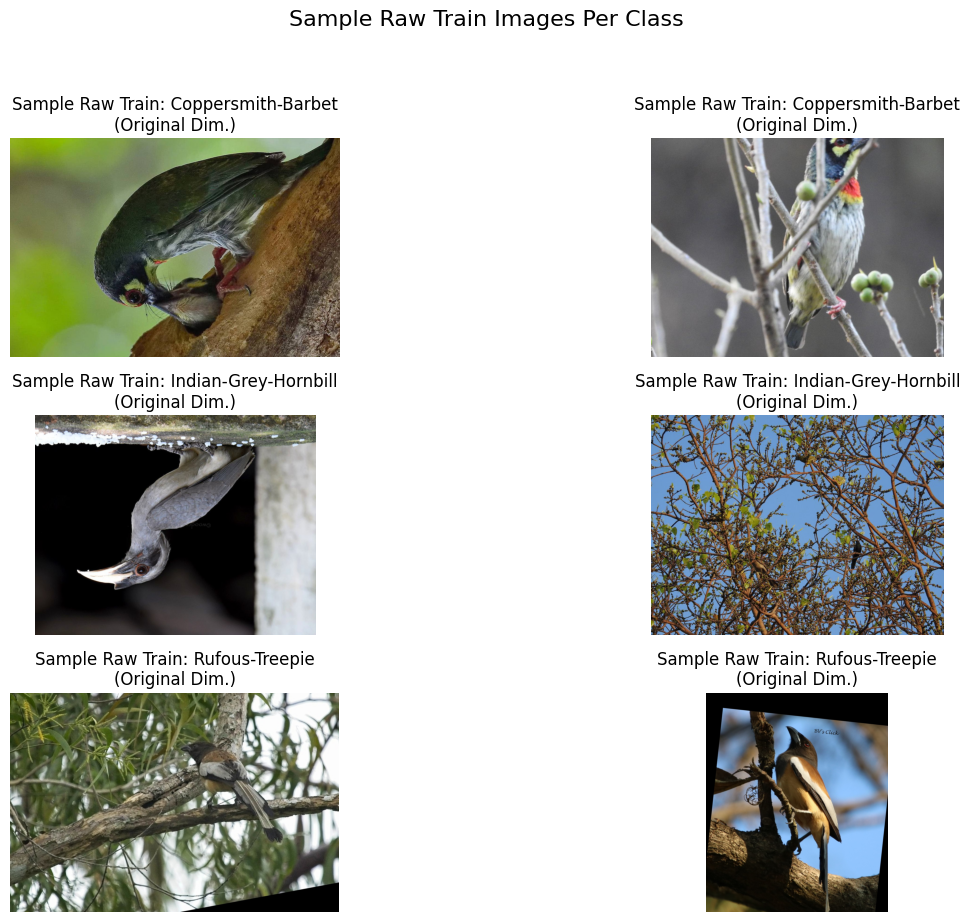


--- Displaying Downscaling Effect (using one training sample) ---


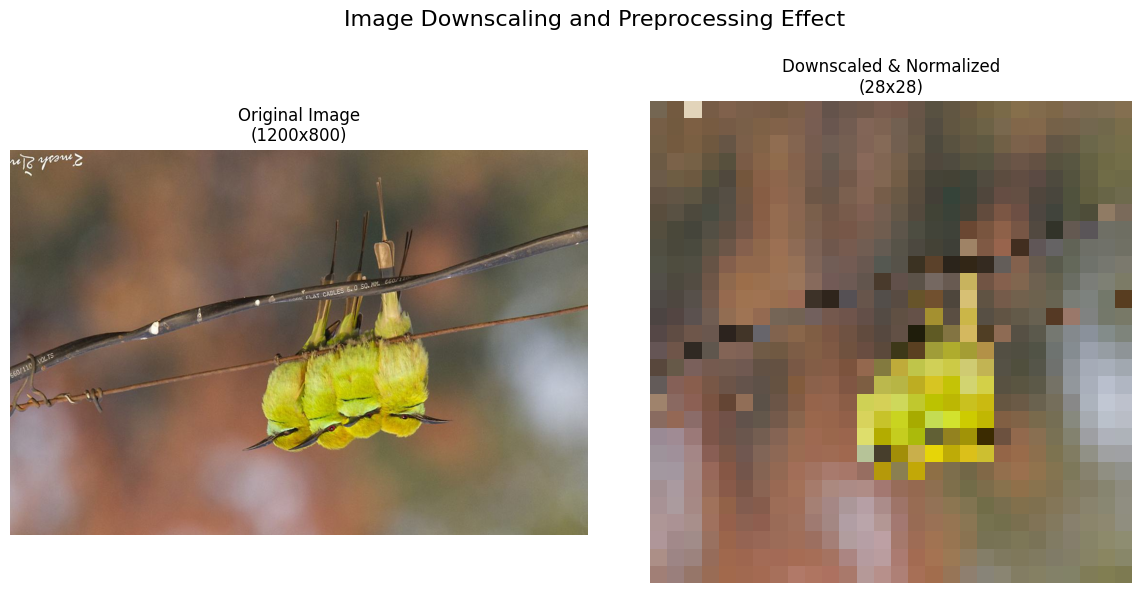


--- Displaying Color Histograms for a few Raw Training Samples ---


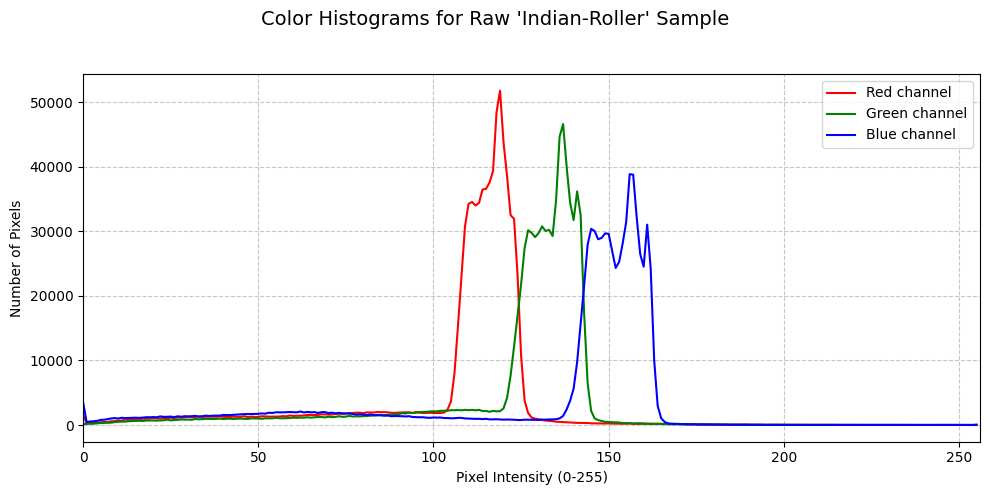

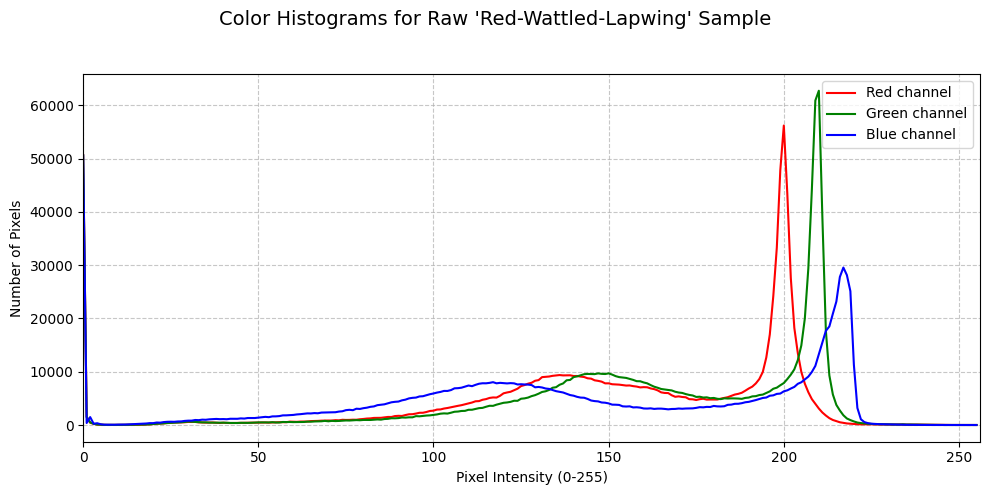


--- Plotting Class Distributions (based on path counts) ---


/tmp/ipykernel_231154/1015853115.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")


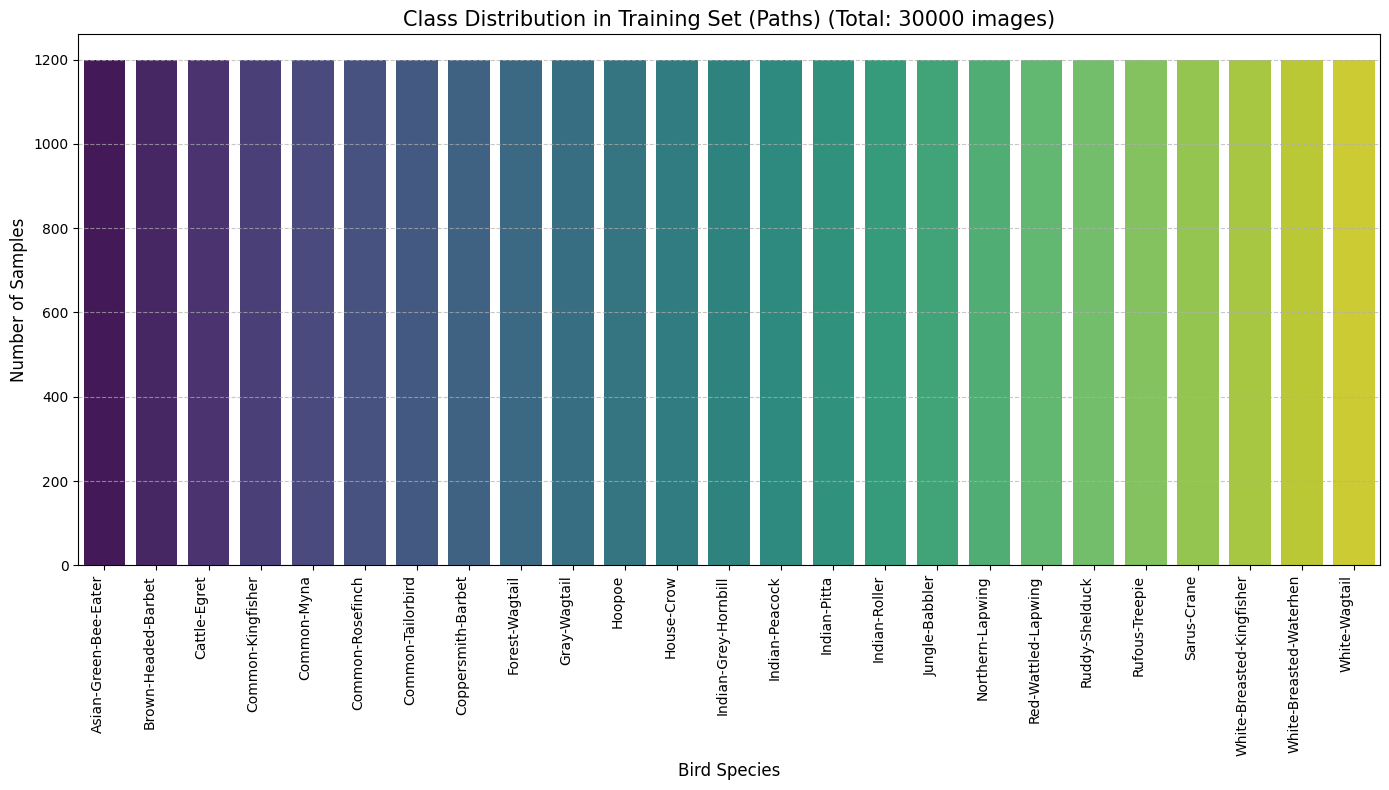

/tmp/ipykernel_231154/1015853115.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")


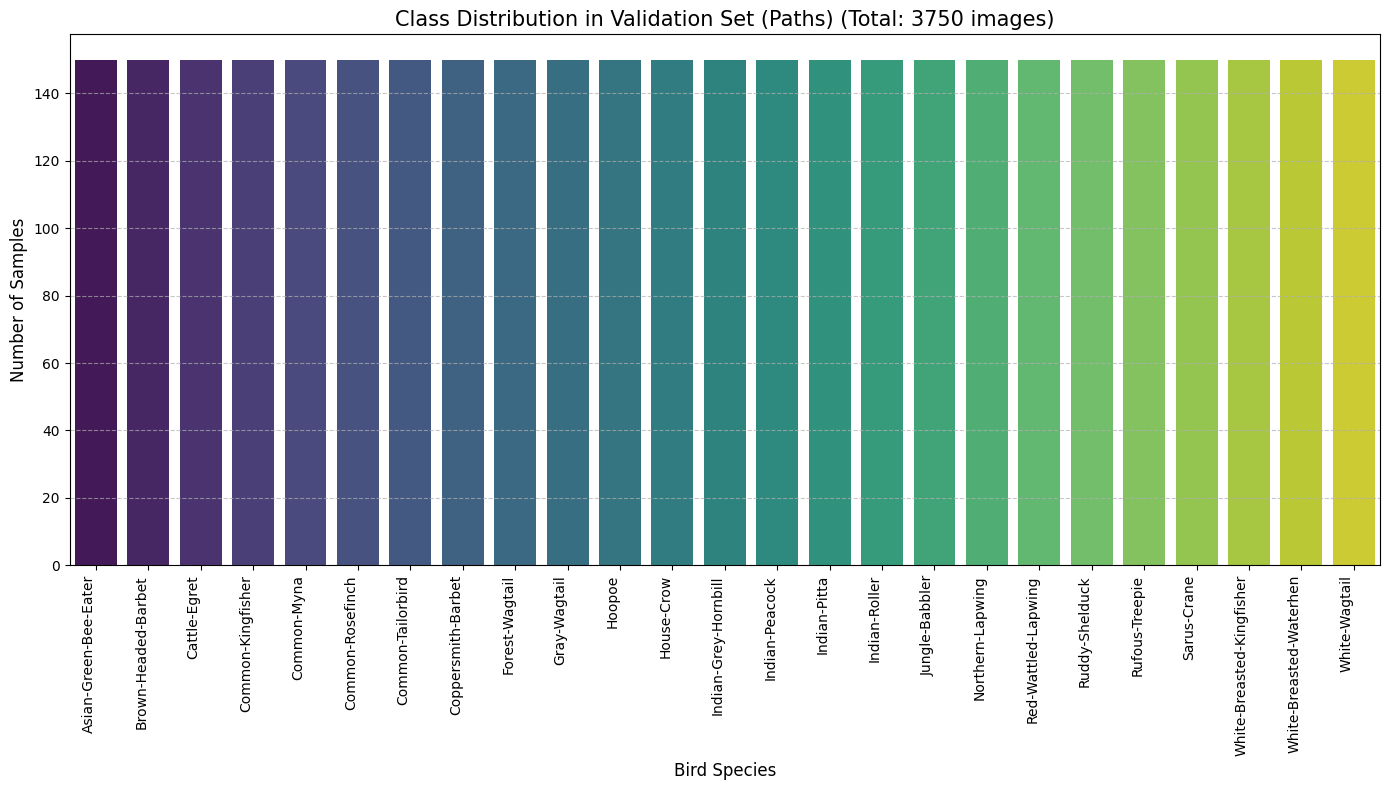

/tmp/ipykernel_231154/1015853115.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")


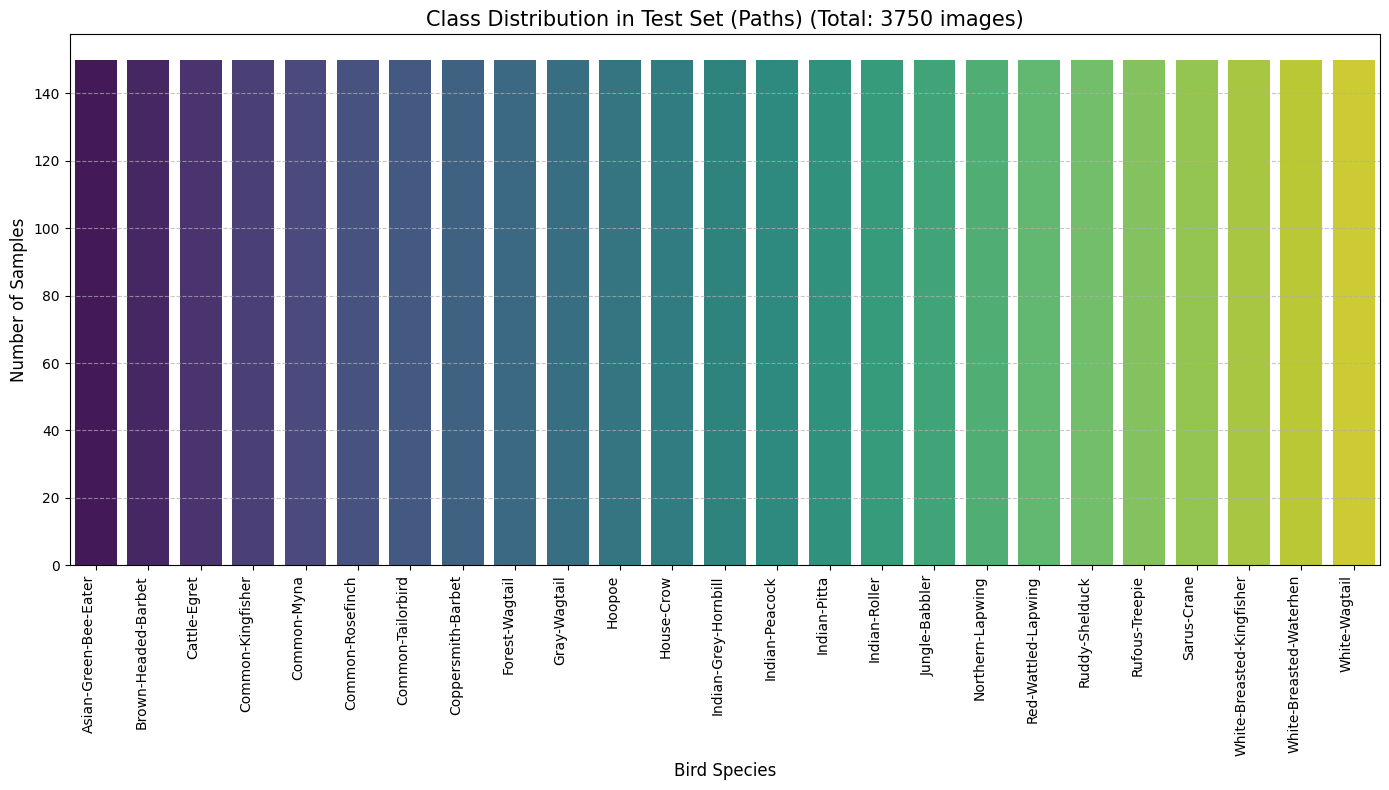

In [8]:

# %% [markdown]
# These visualizations use `load_raw_image_from_path` to show images closer to their original state.

# %% Step 5 Execution
if X_train_paths: # Check if paths were collected
    print("\n--- Displaying Sample Raw Images from Training Paths ---")
    display_sample_images_from_paths(X_train_paths, y_train_labels_encoded, label_mapping,
                                     num_samples_per_class=2, num_classes_to_display=3, title_prefix="Sample Raw Train")

    print("\n--- Displaying Downscaling Effect (using one training sample) ---")
    if X_train_paths:
         show_downscaling_effect_from_path(X_train_paths[0], IMG_WIDTH, IMG_HEIGHT)

    print("\n--- Displaying Color Histograms for a few Raw Training Samples ---")
    if len(X_train_paths) >=2:
        for i in range(2): # Show for 2 samples
            idx = random.randint(0, len(X_train_paths)-1)
            sample_path = X_train_paths[idx]
            raw_img = load_raw_image_from_path(sample_path)
            if raw_img is not None:
                species_name = label_mapping.get(y_train_labels_encoded[idx], "Unknown")
                plot_color_histograms_for_raw_image(raw_img, title=f"Color Histograms for Raw '{species_name}' Sample")
else:
    print("X_train_paths is empty. Skipping raw data visualizations.")


print("\n--- Plotting Class Distributions (based on path counts) ---")
if y_train_labels_encoded.size > 0:
    plot_class_distribution(y_train_labels_encoded, label_mapping, "Training Set (Paths)")
if y_val_labels_encoded.size > 0:
    plot_class_distribution(y_val_labels_encoded, label_mapping, "Validation Set (Paths)")
if y_test_labels_encoded.size > 0:
    plot_class_distribution(y_test_labels_encoded, label_mapping, "Test Set (Paths)")



### Step 6: Load and Preprocess All Data for Model Input


In [9]:

# %% [markdown]
# This step will create `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, `y_test` NumPy arrays with images resized and normalized.
# **WARNING: This can be time-consuming and memory-intensive!**

# %% Step 6 Execution
X_train, y_train, X_val, y_val, X_test, y_test = (np.array([]),)*6 # Initialize empty

if X_train_paths and y_train_labels_encoded.size > 0 :
    print("\n--- Loading and Preprocessing TRAINING Data for Model ---")
    X_train, y_train = load_and_preprocess_data_separated(X_train_paths, y_train_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
    print(f"Model Training data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
else:
    print("Skipping Training data loading due to missing paths or labels.")

if X_val_paths and y_val_labels_encoded.size > 0 :
    print("\n--- Loading and Preprocessing VALIDATION Data for Model ---")
    X_val, y_val = load_and_preprocess_data_separated(X_val_paths, y_val_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
    print(f"Model Validation data shapes: X_val: {X_val.shape}, y_val: {y_val.shape}")
else:
    print("Skipping Validation data loading due to missing paths or labels.")

if X_test_paths and y_test_labels_encoded.size > 0 :
    print("\n--- Loading and Preprocessing TEST Data for Model ---")
    X_test, y_test = load_and_preprocess_data_separated(X_test_paths, y_test_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
    print(f"Model Test data shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
else:
    print("Skipping Test data loading due to missing paths or labels.")

# Optional: One-hot encode labels for CNNs (if needed later)
# y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
# y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
# y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)
# print(f"\nExample one-hot encoded y_train_cat shape: {y_train_cat.shape if y_train_cat.size > 0 else 'N/A'}")


# %% [markdown]
# ## Step 7: Execute Visualizations of Processed Data (Model Input Data)
# These visualizations operate on the `X_train`, etc., arrays which contain images resized to `IMG_WIDTH`x`IMG_HEIGHT` and normalized.

# %% Step 7 Execution
if X_train.size > 0 and y_train.size > 0:
    print("\n--- Displaying Average PROCESSED Images (from X_train) ---")
    display_average_processed_images(X_train, y_train, label_mapping, num_classes_to_display=5)

    print("\n--- Displaying t-SNE of PROCESSED Training Data (subset) ---")
    # Adjust n_samples_subset and perplexity_val as needed.
    # Perplexity should be less than n_samples_subset - 1.
    plot_tsne_visualization_of_processed(X_train, y_train, label_mapping,
                                         n_samples_subset=1000, perplexity_val=30) # Reduced for speed
else:
    print("X_train or y_train is empty. Skipping visualizations of processed data.")

print("\n--- End of Data Loading, Preprocessing, and Visualization Script ---")


--- Loading and Preprocessing TRAINING Data for Model ---
Starting to load and preprocess 30000 images...
  Processed 500/30000 images for current set.
  Processed 1000/30000 images for current set.
  Processed 1500/30000 images for current set.
  Processed 2000/30000 images for current set.
  Processed 2500/30000 images for current set.
  Processed 3000/30000 images for current set.
  Processed 3500/30000 images for current set.
  Processed 4000/30000 images for current set.
  Processed 4500/30000 images for current set.
  Processed 5000/30000 images for current set.
  Processed 5500/30000 images for current set.
  Processed 6000/30000 images for current set.
  Processed 6500/30000 images for current set.
  Processed 7000/30000 images for current set.
  Processed 7500/30000 images for current set.
  Processed 8000/30000 images for current set.
  Processed 8500/30000 images for current set.
  Processed 9000/30000 images for current set.
  Processed 9500/30000 images for current set.
 

KeyboardInterrupt: 

## Part 1: Classification According to Feature Extraction

### Part 1.1: Imports

--- Visualizing Feature Extraction for a Sample Image (with Gabor) ---
Selected image for visualization: Birds_25/train/White-Breasted-Kingfisher/White-Breasted-Kingfisher_1331.jpg
Resized image dimensions: (28, 28, 3)

--- HSV Histogram Visualization ---


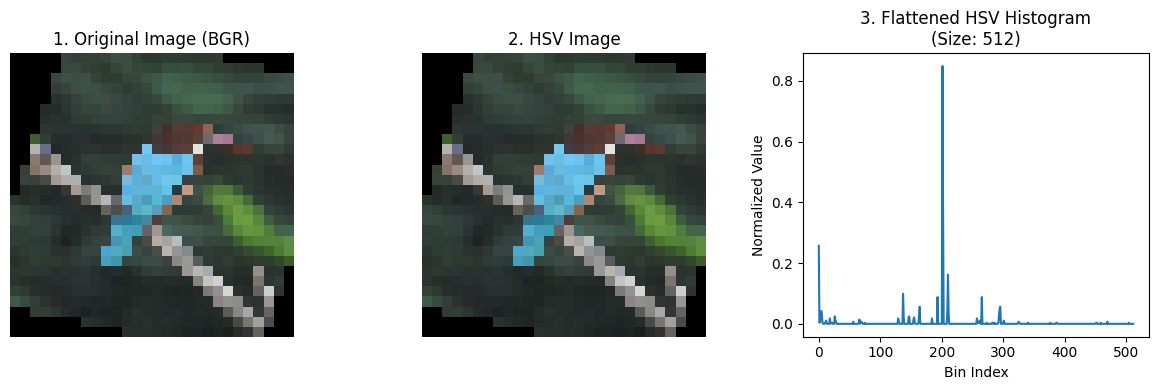


--- HoG Features Visualization ---


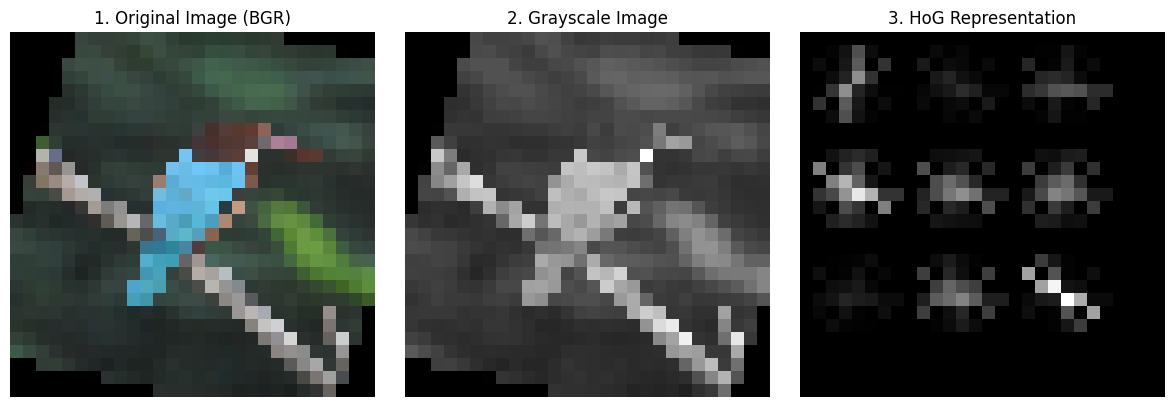

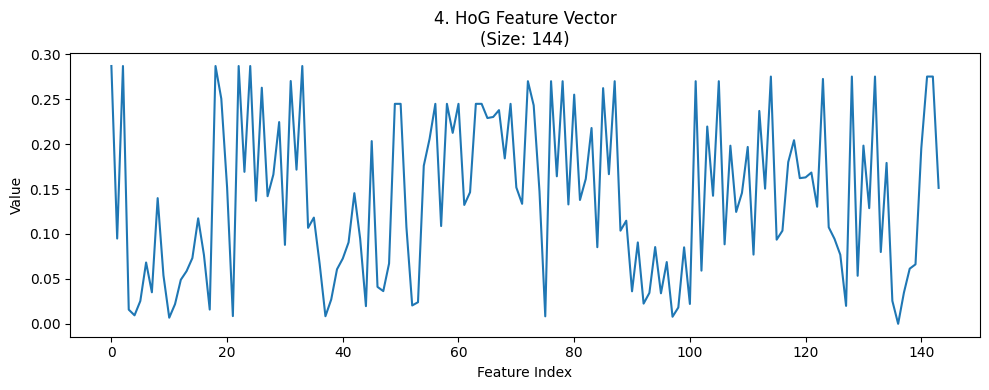


--- Gabor Filter Features Visualization ---


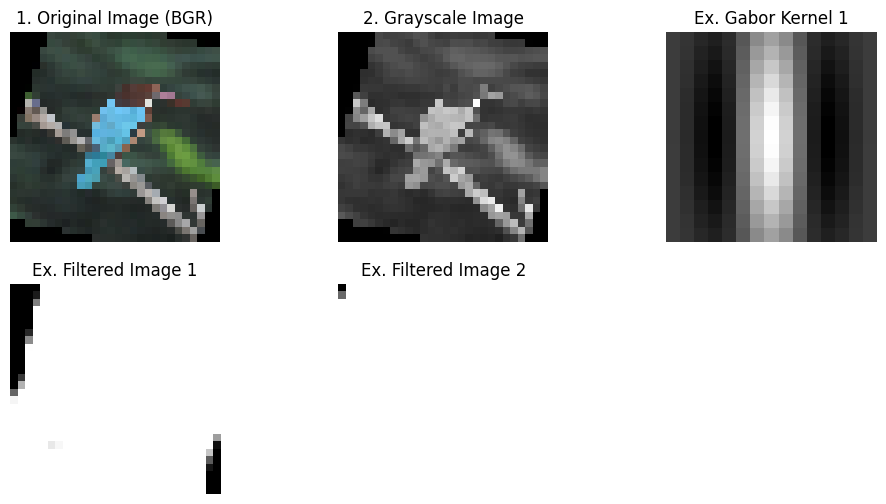

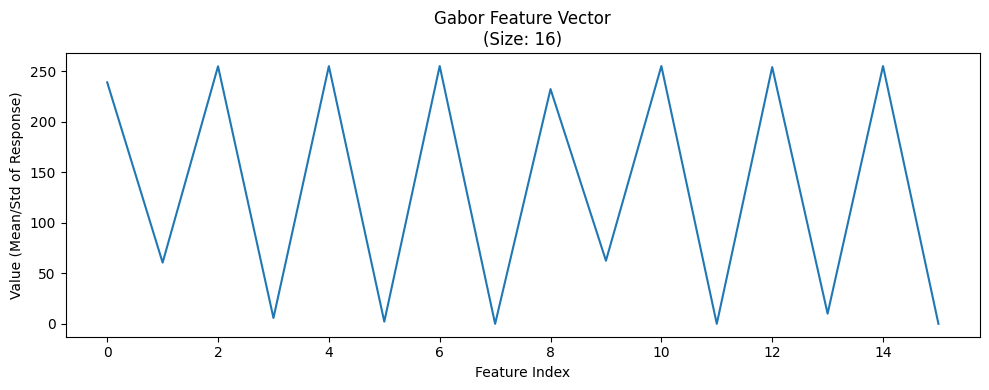


Extracting HSV features...
Starting feature extraction with extract_hsv_histogram_visualized_en for 30000 images...
  Processed 500/30000 images.
  Processed 1000/30000 images.
  Processed 1500/30000 images.
  Processed 2000/30000 images.
  Processed 2500/30000 images.
  Processed 3000/30000 images.
  Processed 3500/30000 images.
  Processed 4000/30000 images.
  Processed 4500/30000 images.
  Processed 5000/30000 images.
  Processed 5500/30000 images.
  Processed 6000/30000 images.
  Processed 6500/30000 images.
  Processed 7000/30000 images.
  Processed 7500/30000 images.
  Processed 8000/30000 images.
  Processed 8500/30000 images.
  Processed 9000/30000 images.
  Processed 9500/30000 images.
  Processed 10000/30000 images.
  Processed 10500/30000 images.
  Processed 11000/30000 images.
  Processed 11500/30000 images.
  Processed 12000/30000 images.
  Processed 12500/30000 images.
  Processed 13000/30000 images.
  Processed 13500/30000 images.
  Processed 14000/30000 images.
  Proce

/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.3385
Test Accuracy: 0.3309
Test Set Classification Report:
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.24      0.27      0.25       150
      Brown-Headed-Barbet       0.24      0.24      0.24       150
             Cattle-Egret       0.30      0.48      0.37       150
        Common-Kingfisher       0.47      0.36      0.41       150
              Common-Myna       0.33      0.27      0.30       150
         Common-Rosefinch       0.31      0.20      0.24       150
        Common-Tailorbird       0.29      0.25      0.27       150
       Coppersmith-Barbet       0.26      0.25      0.26       150
           Forest-Wagtail       0.32      0.38      0.35       150
             Gray-Wagtail       0.26      0.19      0.22       150
                   Hoopoe       0.25      0.35      0.29       150
               House-Crow       0.36      0.31      0.33       150
     Indian-Grey-Hornbill       0.31      0.25

In [35]:
# %% [markdown]
# # Part 1: Classification According to Feature Extraction (Using In-Memory Images & Corrected Labels)

# %% [markdown]
# In this part, we will extract features from the pre-loaded and resized BGR images using:
# 1. Color Histogram (HSV)
# 2. Histogram of Oriented Gradients (HoG)
# 3. Gabor Filters
#
# Then, we will apply at least three basic Machine Learning algorithms to classify the bird species based on these extracted features separately. We'll use Logistic Regression, SVM, Random Forest, and Gaussian Naive Bayes.

# %% Setup: Ensure necessary libraries for Part 1 are imported
# (Most should be in your main setup cell. These are just reminders)
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

# Ensure global parameters IMG_WIDTH, IMG_HEIGHT, NUM_CLASSES, and label_mapping 
# are defined from Part 0
# Example (use actual values from your notebook if different):
# IMG_WIDTH = 128
# IMG_HEIGHT = 128
# NUM_CLASSES = 25

# %% --- Feature Extraction with Visualization Functions (English) ---
# (These functions: extract_hsv_histogram_visualized_en, extract_hog_features_visualized_en,
#  build_gabor_filters, process_with_gabor_filters, extract_gabor_features_visualized_en
#  were provided in the previous response beginning with "Evet, anladım.")
#  Please ensure these functions are defined in a cell before this point.
#  For brevity, they are not repeated here again.

def extract_hsv_histogram_visualized_en(image_bgr, bins=(8, 8, 8), display_visuals=True):
    if image_bgr is None:
        print("Error: Image_bgr is None in HSV Histogram.")
        return None
    if display_visuals:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        plt.title("1. Original Image (BGR)")
        plt.axis('off')
    hsv_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    if display_visuals:
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB))
        plt.title("2. HSV Image")
        plt.axis('off')
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    flat_hist = hist.flatten()
    if display_visuals:
        plt.subplot(1, 3, 3)
        plt.plot(flat_hist)
        plt.title(f"3. Flattened HSV Histogram (Size: {flat_hist.shape[0]})")
        plt.xlabel("Bin Index")
        plt.ylabel("Normalized Value")
        plt.tight_layout()
        plt.show()
    return flat_hist

def extract_hog_features_visualized_en(image_bgr, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, display_visuals=True):
    if image_bgr is None:
        print("Error: Image_bgr is None in HoG.")
        return None
    if display_visuals:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        plt.title("1. Original Image (BGR)")
        plt.axis('off')
    gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    if display_visuals:
        plt.subplot(1, 3, 2)
        plt.imshow(gray_image, cmap='gray')
        plt.title("2. Grayscale Image")
        plt.axis('off')
    features, hog_image_visualization = hog(gray_image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True, transform_sqrt=True)
    if display_visuals:
        hog_image_rescaled = hog_image_visualization / (hog_image_visualization.max() + 1e-6)
        plt.subplot(1, 3, 3)
        plt.imshow(hog_image_rescaled, cmap='gray')
        plt.title("3. HoG Representation")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(10, 4))
        plt.plot(features)
        plt.title(f"4. HoG Feature Vector (Size: {features.shape[0]})")
        plt.xlabel("Feature Index")
        plt.ylabel("Value")
        plt.tight_layout()
        plt.show()
    return features

def build_gabor_filters(ksize=(31, 31), sigma=5.0, lambd=10.0, gamma=0.5, psi=0):
    g_filters = []
    thetas = np.arange(0, np.pi, np.pi / 4)  # 4 orientations
    lambdas = [lambd, lambd * 2] # 2 frequencies (example)
    for theta_val in thetas:
        for lambda_val in lambdas:
            kern = cv2.getGaborKernel(ksize, sigma, theta_val, lambda_val, gamma, psi, ktype=cv2.CV_32F)
            g_filters.append(kern)
    return g_filters

def process_with_gabor_filters(image_gray, gabor_filters_list):
    gabor_features_list = []
    filtered_imgs_list = []
    for i, kern in enumerate(gabor_filters_list):
        fimg = cv2.filter2D(image_gray, cv2.CV_8UC3, kern)
        gabor_features_list.extend([fimg.mean(), fimg.std()])
        if i < 4:
             filtered_imgs_list.append(fimg)
    return np.array(gabor_features_list), filtered_imgs_list
    
def extract_gabor_features_visualized_en(image_bgr, display_visuals=True):
    if image_bgr is None:
        print("Error: Image_bgr is None in Gabor.")
        return None
    ksize = (15, 15); sigma = 3.0; lambd = 10.0; gamma = 0.5; psi = 0 # Tunable parameters
    gabor_kernels_bank = build_gabor_filters(ksize=ksize, sigma=sigma, lambd=lambd, gamma=gamma, psi=psi)
    if display_visuals:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        plt.title("1. Original Image (BGR)")
        plt.axis('off')
    gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    if display_visuals:
        plt.subplot(2, 3, 2)
        plt.imshow(gray_image, cmap='gray')
        plt.title("2. Grayscale Image")
        plt.axis('off')
        if len(gabor_kernels_bank) >= 1:
            plt.subplot(2, 3, 3)
            plt.imshow(gabor_kernels_bank[0], cmap='gray')
            plt.title("Ex. Gabor Kernel 1")
            plt.axis('off')
    gabor_feature_vector, example_filtered_images = process_with_gabor_filters(gray_image, gabor_kernels_bank)
    if display_visuals:
        if len(example_filtered_images) >= 1:
            plt.subplot(2, 3, 4)
            plt.imshow(example_filtered_images[0], cmap='gray')
            plt.title("Ex. Filtered Image 1")
            plt.axis('off')
        if len(example_filtered_images) >= 2:
            plt.subplot(2, 3, 5)
            plt.imshow(example_filtered_images[1], cmap='gray')
            plt.title("Ex. Filtered Image 2")
            plt.axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.95]) # Show the main figure first
        plt.show()
        plt.figure(figsize=(10,4))
        plt.plot(gabor_feature_vector)
        plt.title(f"Gabor Feature Vector (Size: {gabor_feature_vector.shape[0]})")
        plt.xlabel("Feature Index")
        plt.ylabel("Value (Mean/Std of Response)")
        plt.tight_layout()
        plt.show()
    return gabor_feature_vector


# %% --- Part 1: Feature Extraction Visualization Example (Using In-Memory Images) ---
print("--- Visualizing Feature Extraction for a Sample In-Memory Image ---")

# Assuming X_train_images_bgr, y_train_final, IMG_WIDTH, IMG_HEIGHT, label_mapping are defined from Part 0 Update
if 'X_train_images_bgr' in globals() and X_train_images_bgr.size > 0:
    sample_idx_viz = random.randint(0, X_train_images_bgr.shape[0] - 1)
    img_bgr_for_viz = X_train_images_bgr[sample_idx_viz]
    label_for_viz = y_train_final[sample_idx_viz]
    print(f"Visualizing for a sample from training set, class: {label_mapping.get(label_for_viz, 'Unknown') if 'label_mapping' in globals() else label_for_viz}")

    print("\n--- HSV Histogram Visualization ---")
    _ = extract_hsv_histogram_visualized_en(img_bgr_for_viz.copy(), display_visuals=True)
    
    print("\n--- HoG Features Visualization ---")
    _ = extract_hog_features_visualized_en(img_bgr_for_viz.copy(), pixels_per_cell=(8,8), cells_per_block=(2,2), display_visuals=True) # Adjust HoG params if your IMG_WIDTH/HEIGHT is large
    
    print("\n--- Gabor Filter Features Visualization ---")
    _ = extract_gabor_features_visualized_en(img_bgr_for_viz.copy(), display_visuals=True)
else:
    print("X_train_images_bgr is empty or not defined. Cannot run visualization example. Ensure Part 0 Update cell was executed.")


# %% --- Part 1: NEW Function to Extract All Features from Pre-loaded Image Arrays ---
def extract_all_features_from_images_optimized(image_array_bgr, feature_extractor_func, **kwargs):
    features_list = []
    if image_array_bgr is None or image_array_bgr.size == 0:
        print(f"Warning: Input image_array_bgr for {feature_extractor_func.__name__} is empty. Returning empty feature list.")
        return np.array(features_list)
        
    print(f"Starting feature extraction with {feature_extractor_func.__name__} for {image_array_bgr.shape[0]} images...")
    for i in range(image_array_bgr.shape[0]):
        img_bgr = image_array_bgr[i] 
        
        features = feature_extractor_func(img_bgr.copy(), display_visuals=False, **kwargs) # display_visuals=False for bulk
        if features is not None:
            features_list.append(features)
        else:
            # This case should be rare if images were pre-filtered in Part 0 Update
            print(f"Warning: Feature extraction returned None for image at index {i}, skipping this image's features.")

        if (i + 1) % 500 == 0 or (i + 1) == image_array_bgr.shape[0]:
            print(f"  Processed {i+1}/{image_array_bgr.shape[0]} images.")
            
    num_successfully_extracted = len(features_list)
    print(f"Finished. Successfully extracted features for {num_successfully_extracted} images.")
    
    # Handle case where no features are extracted from any image for a particular extractor
    if num_successfully_extracted == 0 and image_array_bgr.shape[0] > 0:
        print(f"CRITICAL WARNING: No features were extracted from {image_array_bgr.shape[0]} images using {feature_extractor_func.__name__}. Check feature_extractor_func or image quality.")
        # Determine expected feature dimension if possible, otherwise return empty array of shape (0,0) or (0,)
        # This is tricky without knowing the feature_dim beforehand if all fail.
        # For robustness, we can try to extract from first image to get dim.
        if image_array_bgr.shape[0] > 0:
            temp_feat = feature_extractor_func(image_array_bgr[0].copy(), display_visuals=False, **kwargs)
            if temp_feat is not None:
                return np.empty((0, temp_feat.shape[0])) 
        return np.array([]) # Fallback: truly empty array

    return np.array(features_list)


# %% --- Part 1: Extracting All Features for Train, Validation, and Test Sets (Optimized) ---

# Assuming X_train_images_bgr, X_val_images_bgr, X_test_images_bgr are available from Part 0 Update
# These arrays contain the actual BGR image data, resized.

# HSV Features
print("\nExtracting HSV features...")
X_train_hsv = extract_all_features_from_images_optimized(X_train_images_bgr, extract_hsv_histogram_visualized_en, bins=(8,8,8))
X_val_hsv = extract_all_features_from_images_optimized(X_val_images_bgr, extract_hsv_histogram_visualized_en, bins=(8,8,8))
X_test_hsv = extract_all_features_from_images_optimized(X_test_images_bgr, extract_hsv_histogram_visualized_en, bins=(8,8,8))

# HoG Features
print("\nExtracting HoG features...")
# Adjust HoG parameters (pixels_per_cell, cells_per_block) based on your IMG_WIDTH/IMG_HEIGHT if needed
X_train_hog = extract_all_features_from_images_optimized(X_train_images_bgr, extract_hog_features_visualized_en, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9)
X_val_hog = extract_all_features_from_images_optimized(X_val_images_bgr, extract_hog_features_visualized_en, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9)
X_test_hog = extract_all_features_from_images_optimized(X_test_images_bgr, extract_hog_features_visualized_en, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9)

# Gabor Features
print("\nExtracting Gabor features...")
X_train_gabor = extract_all_features_from_images_optimized(X_train_images_bgr, extract_gabor_features_visualized_en)
X_val_gabor = extract_all_features_from_images_optimized(X_val_images_bgr, extract_gabor_features_visualized_en)
X_test_gabor = extract_all_features_from_images_optimized(X_test_images_bgr, extract_gabor_features_visualized_en)


print("\n--- Feature Extraction Shapes (Optimized) ---")
# These feature array shapes should now match the filtered label array shapes from Part 0 Update
# (y_train_final, y_val_final, y_test_final)
if hasattr(X_train_hsv, 'shape') and X_train_hsv.size > 0: print(f"X_train_hsv shape: {X_train_hsv.shape}, y_train_final shape: {y_train_final.shape}")
else: print(f"X_train_hsv is empty or y_train_final is unavailable.")

if hasattr(X_val_hsv, 'shape') and X_val_hsv.size > 0: print(f"X_val_hsv shape: {X_val_hsv.shape}, y_val_final shape: {y_val_final.shape}")
elif hasattr(X_val_images_bgr, 'shape') and X_val_images_bgr.size > 0 : print(f"X_val_hsv is empty, but y_val_final shape is {y_val_final.shape if hasattr(y_val_final, 'shape') else 'N/A'}")
else: print(f"X_val_hsv and source images X_val_images_bgr are empty or y_val_final is unavailable.")

if hasattr(X_test_hsv, 'shape') and X_test_hsv.size > 0: print(f"X_test_hsv shape: {X_test_hsv.shape}, y_test_final shape: {y_test_final.shape}")
elif hasattr(X_test_images_bgr, 'shape') and X_test_images_bgr.size > 0 : print(f"X_test_hsv is empty, but y_test_final shape is {y_test_final.shape if hasattr(y_test_final, 'shape') else 'N/A'}")
else: print(f"X_test_hsv and source images X_test_images_bgr are empty or y_test_final is unavailable.")


# Similar print statements for HoG and Gabor
if hasattr(X_train_hog, 'shape') and X_train_hog.size > 0: print(f"X_train_hog shape: {X_train_hog.shape}")
if hasattr(X_train_gabor, 'shape') and X_train_gabor.size > 0: print(f"X_train_gabor shape: {X_train_gabor.shape}")


# %% --- Part 1: Training and Evaluating ML Models (Using Pre-loaded Images and Globally Filtered Labels) ---

# Store features in dictionaries (these now directly correspond to the filtered y_train_final, y_val_final, y_test_final)
feature_data_train_opt = {
    "HSV": X_train_hsv,
    "HoG": X_train_hog,
    "Gabor": X_train_gabor
}
feature_data_val_opt = {
    "HSV": X_val_hsv,
    "HoG": X_val_hog,
    "Gabor": X_val_gabor
}
feature_data_test_opt = {
    "HSV": X_test_hsv,
    "HoG": X_test_hog,
    "Gabor": X_test_gabor
}

# Define ML models to try (ensure ml_models is defined, or define it here)
if 'ml_models' not in globals():
    ml_models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, solver='saga', multi_class='multinomial', C=0.1, random_state=42, n_jobs=-1),
        "SVM (Linear Kernel)": SVC(kernel='linear', C=0.1, probability=True, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1),
        "Gaussian Naive Bayes": GaussianNB()
    }

# Ensure target_names_part1 is defined (should be from your Part 0 Update using label_mapping)
if 'target_names_part1' not in globals():
    if 'label_mapping' in globals():
        target_names_part1 = [label_mapping[i] for i in sorted(label_mapping.keys())]
    elif 'NUM_CLASSES' in globals() and NUM_CLASSES > 0: #
        target_names_part1 = [str(i) for i in range(NUM_CLASSES)]
        print("Warning: label_mapping not found. Using default numerical target names for classification report.")
    else:
        # Attempt to derive from y_train_final if it exists and is not empty
        if 'y_train_final' in globals() and y_train_final.size > 0:
            unique_labels_runtime = np.unique(y_train_final)
            target_names_part1 = [str(i) for i in unique_labels_runtime]
            print(f"Warning: label_mapping and NUM_CLASSES not found. Using unique labels from y_train_final for target names ({len(unique_labels_runtime)} classes).")
        else:
            target_names_part1 = None 
            print("Warning: label_mapping, NUM_CLASSES, and y_train_final are unavailable. Classification report may use numerical labels or fail if target_names are required and None.")


results_part1_optimized = [] 

for feature_name, X_train_feat_opt in feature_data_train_opt.items():
    X_val_feat_opt = feature_data_val_opt.get(feature_name)
    X_test_feat_opt = feature_data_test_opt.get(feature_name)

    # Use the globally filtered y_train_final, y_val_final, y_test_final
    # These should already be aligned with X_..._images_bgr
    current_y_train = y_train_final
    current_y_val = y_val_final
    current_y_test = y_test_final
    
    # Check if feature extraction was successful for this set & if labels exist
    if X_train_feat_opt is None or X_train_feat_opt.size == 0 or current_y_train.size == 0:
        print(f"\nSkipping {feature_name} for training: X_train_feat is empty or labels are missing.")
        continue
    if X_train_feat_opt.shape[0] != current_y_train.shape[0]:
        print(f"CRITICAL MISMATCH for training {feature_name}: Features {X_train_feat_opt.shape[0]}, Labels {current_y_train.shape[0]}. This should not happen with pre-filtering. Skipping.")
        continue
        
    # Validation and Test sets might be empty if original path lists were empty
    # or all images in them failed to load/process.
    run_validation = X_val_feat_opt is not None and X_val_feat_opt.size > 0 and current_y_val.size > 0 and X_val_feat_opt.shape[0] == current_y_val.shape[0]
    run_test = X_test_feat_opt is not None and X_test_feat_opt.size > 0 and current_y_test.size > 0 and X_test_feat_opt.shape[0] == current_y_test.shape[0]

    print(f"\n===== Evaluating ML Models with {feature_name} Features (Optimized Loading) =====")
    print(f"Train shapes: X-{X_train_feat_opt.shape}, y-{current_y_train.shape}")
    if run_validation: print(f"Val shapes: X-{X_val_feat_opt.shape}, y-{current_y_val.shape}")
    else: print("Validation set is empty or mismatched, skipping validation evaluation.")
    if run_test: print(f"Test shapes: X-{X_test_feat_opt.shape}, y-{current_y_test.shape}")
    else: print("Test set is empty or mismatched, skipping test evaluation.")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_feat_opt)
    X_val_scaled = scaler.transform(X_val_feat_opt) if run_validation else np.array([])
    X_test_scaled = scaler.transform(X_test_feat_opt) if run_test else np.array([])
    
    # Get unique labels present in the current training set for classification report
    # This handles cases where some classes might be missing after filtering
    unique_labels_in_train = np.unique(current_y_train)
    current_target_names = [label_mapping[i] for i in unique_labels_in_train] if target_names_part1 and 'label_mapping' in globals() else [str(i) for i in unique_labels_in_train]


    for model_name, model_instance_orig in ml_models.items():
        print(f"\n--- Training {model_name} with {feature_name} ---")
        start_time = time.time()
        
        current_model = type(model_instance_orig)(**model_instance_orig.get_params())
        if 'random_state' in current_model.get_params():
            current_model.set_params(random_state=42)
        if hasattr(current_model, 'n_jobs') and model_name != "Gaussian Naive Bayes": # GaussianNB doesn't have n_jobs
             current_model.set_params(n_jobs=-1)

        try:
            current_model.fit(X_train_scaled, current_y_train)
            train_time = time.time() - start_time

            val_accuracy = 0.0
            val_report_dict_default = {'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0}}
            if run_validation and X_val_scaled.size > 0 :
                y_val_pred = current_model.predict(X_val_scaled)
                val_accuracy = accuracy_score(current_y_val, y_val_pred)
                unique_labels_in_val_true_pred = np.unique(np.concatenate([current_y_val, y_val_pred]))
                val_target_names_runtime = [label_mapping[i] for i in unique_labels_in_val_true_pred] if target_names_part1 and 'label_mapping' in globals() else [str(i) for i in unique_labels_in_val_true_pred]
                val_report_dict = classification_report(current_y_val, y_val_pred, target_names=val_target_names_runtime, labels=unique_labels_in_val_true_pred, output_dict=True, zero_division=0)
                print(f"Validation Accuracy: {val_accuracy:.4f}")
            else:
                val_report_dict = val_report_dict_default
                print("Validation evaluation skipped.")

            test_accuracy = 0.0
            test_report_str = "N/A (Test set empty or mismatched)"
            test_report_dict_default = {'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0}}
            test_time_val = 0.0

            if run_test and X_test_scaled.size > 0:
                start_test_time = time.time()
                y_test_pred = current_model.predict(X_test_scaled)
                test_time_val = time.time() - start_test_time
                
                test_accuracy = accuracy_score(current_y_test, y_test_pred)
                unique_labels_in_test_true_pred = np.unique(np.concatenate([current_y_test, y_test_pred]))
                test_target_names_runtime = [label_mapping[i] for i in unique_labels_in_test_true_pred] if target_names_part1 and 'label_mapping' in globals() else [str(i) for i in unique_labels_in_test_true_pred]

                test_report_str = classification_report(current_y_test, y_test_pred, target_names=test_target_names_runtime, labels=unique_labels_in_test_true_pred, zero_division=0)
                test_report_dict = classification_report(current_y_test, y_test_pred, target_names=test_target_names_runtime, labels=unique_labels_in_test_true_pred, output_dict=True, zero_division=0)
                print(f"Test Accuracy: {test_accuracy:.4f}")
                print("Test Set Classification Report:")
                print(test_report_str)
            else:
                test_report_dict = test_report_dict_default
                print("Test evaluation skipped.")
            
            results_part1_optimized.append({
                "Feature Set": feature_name,
                "ML Model": model_name,
                "Validation Accuracy": round(val_accuracy, 4),
                "Test Accuracy": round(test_accuracy, 4),
                "Test Precision (macro)": round(test_report_dict['macro avg']['precision'], 4),
                "Test Recall (macro)": round(test_report_dict['macro avg']['recall'], 4),
                "Test F1-Score (macro)": round(test_report_dict['macro avg']['f1-score'], 4),
                "Training Time (s)": round(train_time, 2),
                "Test Time (s)": round(test_time_val, 2)
            })
        except Exception as e:
            print(f"Error training/evaluating {model_name} with {feature_name}: {e}")

# %% --- Part 1: Displaying Optimized Results ---
print("\n\n--- Summary of Part 1 Results (Optimized Loading & Corrected Labels) ---")
df_results_part1_optimized = pd.DataFrame(results_part1_optimized)
if not df_results_part1_optimized.empty:
    df_results_part1_sorted_optimized = df_results_part1_optimized.sort_values(by="Test Accuracy", ascending=False)
    print(df_results_part1_sorted_optimized.to_string())
else:
    print("No results to display for Part 1 (Optimized). Check for errors during feature extraction or model training.")

# %% [markdown]
# ## Part 1: Comments and Interpretations
#
# *(This is where you will write your analysis based on the results obtained above. Consider the performance of different feature extractors with different ML models, training times, and any challenges faced.)*

### Part 1.2: Feature Extraction Funcitons with Visualization Functions


### Part 1.4: Feature Extraction Methods Visualized

### Part 1.5: Running The Experiment